Focal Length: 40 mm
  New Waist Size (W0): 0.06 mm
  Waist Location (z0): 38.19 mm

Focal Length: 100 mm
  New Waist Size (W0): 0.13 mm
  Waist Location (z0): 64.32 mm

Focal Length: 150 mm
  New Waist Size (W0): 0.15 mm
  Waist Location (z0): 64.32 mm



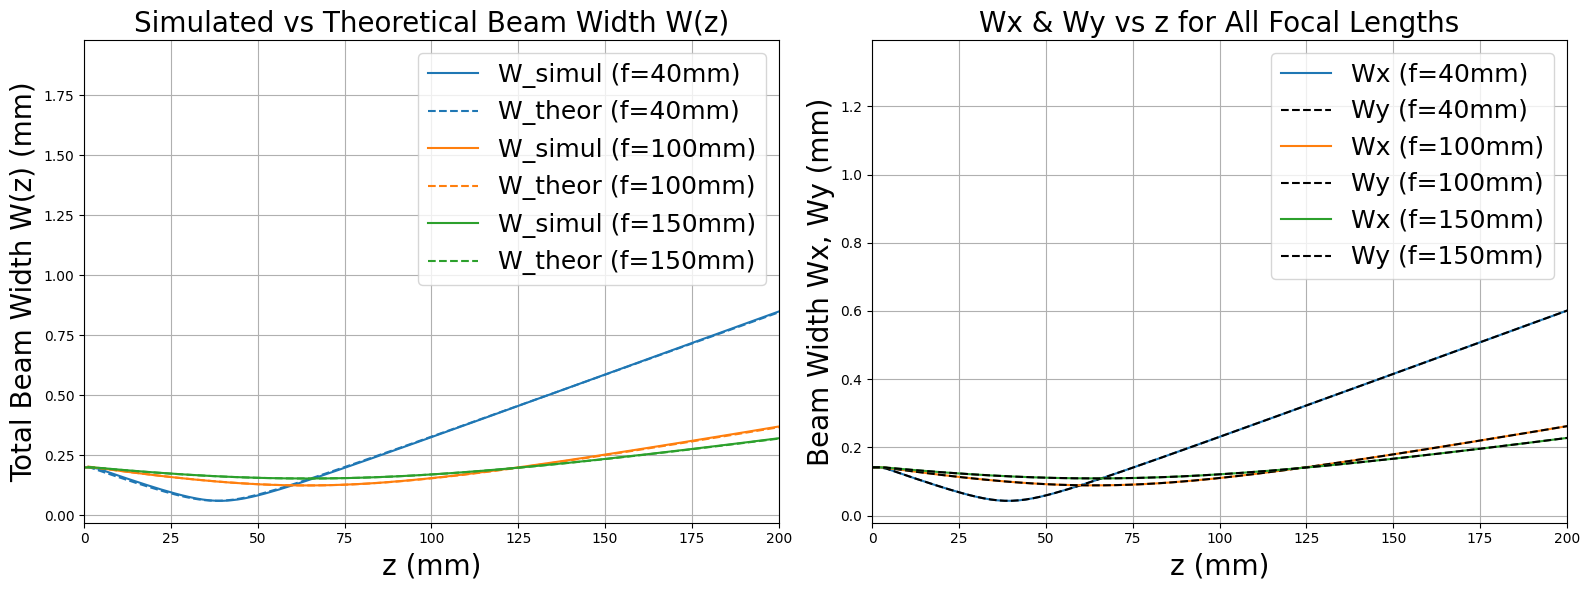

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Beam propagation using angular spectrum method
def angular_spectrum_method_with_padding(field, z_arr, wavelength, dx, dy, pad_width, alpha, bandwidth_limit=True):
    k = 2 * np.pi / wavelength
    padded_field = np.pad(field, ((pad_width, pad_width), (pad_width, pad_width)), mode='constant')
    Nx, Ny = padded_field.shape
    x = np.linspace(-1, 1, Nx)
    y = np.linspace(-1, 1, Ny)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    absorption_mask = np.exp(-alpha * np.maximum(r - 1 + 2 * pad_width / max(Nx, Ny), np.zeros_like(r))**2)
    padded_field *= absorption_mask
    field_ft = np.fft.fft2(padded_field)
    kx = np.fft.fftfreq(Nx, dx) * 2 * np.pi
    ky = np.fft.fftfreq(Ny, dy) * 2 * np.pi
    kx, ky = np.meshgrid(kx, ky, indexing="ij")

    if bandwidth_limit:
        k_max = k
        mask = (kx**2 + ky**2 <= k_max**2)
        field_ft *= mask

    kz = np.sqrt(np.clip(k**2 - kx**2 - ky**2, 0, None))
    propagated_fields = np.empty((len(z_arr), field.shape[0], field.shape[1]), dtype=np.complex128)

    for count, z in enumerate(z_arr):
        phase_factor = np.exp(1j * kz * z)
        propagated_field_ft = field_ft * phase_factor
        propagated_field = np.fft.ifft2(propagated_field_ft)
        propagated_field = propagated_field[pad_width:-pad_width, pad_width:-pad_width]
        propagated_fields[count, :, :] = propagated_field

    return propagated_fields

# Second moment calculation
def second_moment(x, y, I):
    numx = np.trapz(np.trapz(I * x**2, x, axis=0), y, axis=0)
    numy = np.trapz(np.trapz(I * y**2, y, axis=0), x, axis=0)
    den = np.trapz(np.trapz(I, y, axis=0), x, axis=0)
    return numx, numy, den

# Calculate the beam radius in x and y directions for all positions in z
def beam_width(Wx, Wy):
    W = np.sqrt(Wx**2 + Wy**2)
    return W

# Parameters
wavelength = 1e-3  # Wavelength in mm
Wo = 0.2  # Beam waist in mm
pad_width = 140  # Padding width
abs_coeff = 16  # Absorption coefficient

# Grid parameters
grid_size = 500
grid_extent = 5.8  # Reduced extent of the grid in mm for finer detail
dx = dy = grid_extent / grid_size

# Lens positions and focal lengths
lens_position = 1  # Position of lens in mm
focal_lengths = [40, 100,  150]  # Focal lengths in mm

# Coordinate grid
x = np.linspace(-grid_extent / 2, grid_extent / 2, grid_size)
y = np.linspace(-grid_extent / 2, grid_extent / 2, grid_size)
X, Y = np.meshgrid(x, y)

# Initial Gaussian beam field
initial_field = np.exp(-(X**2 + Y**2) / Wo**2)

# Array for position in z axis
z_positions = np.linspace(0, 400, 200)

# Lists to hold results for each focal length
all_Wx = []
all_Wy = []
all_W_sim = []
all_W_th = []

# Loop over focal lengths and calculate
for f in focal_lengths:
    # Propagate the field
    z_to_lens = np.linspace(0, lens_position, 2)
    field_to_lens = angular_spectrum_method_with_padding(initial_field, z_to_lens, wavelength, dx, dy, pad_width, abs_coeff)
    field_at_lens = field_to_lens[-1, :, :]

    # Apply lens phase transformation
    lens_phase = np.exp(((-1j * np.pi) / (wavelength * f)) * (X**2 + Y**2))
    field_after_lens = field_at_lens * lens_phase

    # Propagate field after lens
    z_after_lens = np.linspace(lens_position, 400, len(z_positions) - 1)
    field_after_lens_all_z = angular_spectrum_method_with_padding(field_after_lens, z_after_lens, wavelength, dx, dy, pad_width, abs_coeff)

    # Combine fields before and after the lens
    propag_field = np.concatenate((field_to_lens, field_after_lens_all_z), axis=0)

    # Compute the intensity profile
    intensity = np.abs(propag_field)**2

    # Calculate the beam radii Wx and Wy
    Wx = np.zeros(len(z_positions))
    Wy = np.zeros(len(z_positions))

    for i in range(len(z_positions)):
        numx, numy, den = second_moment(x, y, intensity[i])
        Wx[i] = np.sqrt(2 * numx / den)
        Wy[i] = np.sqrt(2 * numy / den)

    # Simulated beam width W
    W_sim = beam_width(Wx, Wy)
  
    # Store results for plotting
    all_Wx.append(Wx)
    all_Wy.append(Wy)
    all_W_sim.append(W_sim)

# Calculate new waist and waist location for each focal length
waist_locations = []
waist_sizes = []

for W_sim in all_W_sim:
    min_W = np.min(W_sim)  # Minimum beam width (new waist size)
    z_min_W = z_positions[np.argmin(W_sim)]  # Position of minimum beam width (waist location)
    waist_locations.append(z_min_W)
    waist_sizes.append(min_W)

# Print the results
for i, f in enumerate(focal_lengths):
    print(f"Focal Length: {f} mm")
    print(f"  New Waist Size (W0): {waist_sizes[i]:.2f} mm")
    print(f"  Waist Location (z0): {waist_locations[i]:.2f} mm\n")

# Define range of z values from lens_position to 400 mm
z_range = np.linspace(lens_position, 400, 200)

# Calculate theoretical beam widths and store them in `theoretical_Wz`
theoretical_Wz = []

for i, f in enumerate(focal_lengths):
    # Extract the calculated waist size and location for this focal length
    W0 = waist_sizes[i]
    z0 = waist_locations[i]
    
    # Calculate Rayleigh range
    z_R = np.pi * W0**2 / wavelength
    
    # Calculate theoretical W(z) for each z in z_range
    Wz = W0 * np.sqrt(1 + ((z_range - z0) / z_R)**2)
    theoretical_Wz.append(Wz)

# Create subplots with side-by-side layout
fig, ax = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot 1: Wx and Wy vs z for all focal lengths
for i, f in enumerate(focal_lengths):
    ax[1].plot(z_positions, all_Wx[i], label=f'Wx (f={f}mm)', linestyle='-', color=f'C{i}')
    ax[1].plot(z_positions, all_Wy[i], label=f'Wy (f={f}mm)', linestyle='--', color='black')

# Labels and title for the second plot
ax[1].set_xlabel('z (mm)', fontsize=20)
ax[1].set_ylabel('Beam Width Wx, Wy (mm)', fontsize=20)
ax[1].set_title('Wx & Wy vs z for All Focal Lengths', fontsize=20)
ax[1].legend(fontsize=18)
ax[1].grid(True)
ax[1].set_xlim(0, 200)  # Set the z range to 0 to 200


# Plot 2: Simulated vs. Theoretical Total Beam Width
for i, f in enumerate(focal_lengths):
    # Plot the simulated total beam width
    ax[0].plot(z_positions, all_W_sim[i], label=f'W_simul (f={f}mm)', linestyle='-', color=f'C{i}')
    
    # Plot the theoretical total beam width, using the same color but different linestyle
    ax[0].plot(z_range, theoretical_Wz[i], label=f'W_theor (f={f}mm)', linestyle='--', color=f'C{i}')

# Labels and title for the first plot
ax[0].set_xlabel('z (mm)', fontsize=20)
ax[0].set_ylabel('Total Beam Width W(z) (mm)', fontsize=20)
ax[0].set_title('Simulated vs Theoretical Beam Width W(z)', fontsize=20)
ax[0].legend(fontsize=18)
ax[0].grid(True)
ax[0].set_xlim(0, 200)  # Set the z range to 0 to 200


# Adjust layout
plt.tight_layout()

# Show the figure
plt.show()